In [56]:
import os
import random
from typing import Tuple

import pandas as pd
import numpy as np
from PIL import Image
from tqdm.notebook import tqdm
import torch
from torch.nn import functional as F
import torch.nn as nn
from torch import optim
from torch.utils.data import Dataset, DataLoader
from torchvision import models, transforms
from torchvision.transforms.functional import InterpolationMode
from torchinfo import summary

import matplotlib.pyplot as plt
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import plotly.express as px

In [57]:
path_spectograms = os.path.join(os.getcwd(), 'spectograms')

df = pd.read_csv('data_multimodal.csv')

df_spect = df.loc[:, ['Sentiment', 'Score', 'Type', 'Spectogram']].drop_duplicates().reset_index(drop=True).copy()
df_spect['PathSpectogram'] = df_spect['Spectogram'].apply(lambda x: os.path.join(path_spectograms, x))

In [58]:
df_spect.head()

,Sentiment,Score,Type,Spectogram,PathSpectogram
0,positive,2.4,train,03bSnISJMiM_1_spect.jpg,C:\ELTE\AppliedDeepLearning\Assignments\Assign...
1,negative,-1.2,train,03bSnISJMiM_10_spect.jpg,C:\ELTE\AppliedDeepLearning\Assignments\Assign...
2,negative,-0.5,train,03bSnISJMiM_11_spect.jpg,C:\ELTE\AppliedDeepLearning\Assignments\Assign...
3,positive,2.2,train,03bSnISJMiM_12_spect.jpg,C:\ELTE\AppliedDeepLearning\Assignments\Assign...
4,positive,1.8,train,03bSnISJMiM_13_spect.jpg,C:\ELTE\AppliedDeepLearning\Assignments\Assign...


In [59]:
len(df_spect)

2199

In [60]:
class SpectogramDataset(Dataset):
    
    def __init__(self, df, transforms):
        
        self.path_spectograms = df['PathSpectogram'].tolist()
        self.labels = list(map(lambda x: 1 if x == 'positive' else 0, df['Sentiment'].tolist()))
        self.transforms = transforms
        
    def __len__(self):
        return len(self.path_spectograms)
    
    def __getitem__(self, idx):
        
        image = Image.open(self.path_spectograms[idx])
        label = self.labels[idx]
        image = self.transforms(image)
            
        return image, label
    

def train(dataloader, model, criterion, optimizer, device):
    
    model.train()
    epoch_losses = []
    epoch_accs = []
    
    for batch in tqdm(dataloader):
        
        images, labels = batch
        images = images.to(device)
        labels = labels.to(device)
        predictions = model(images)
        loss = criterion(predictions, labels)
        accuracy = get_accuracy(predictions, labels)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        epoch_losses.append(loss.item())
        epoch_accs.append(accuracy.item())
        
    return np.mean(epoch_losses), np.mean(epoch_accs)


def evaluate(dataloader, model, criterion, device):
    
    model.eval()
    epoch_losses = []
    epoch_accs = []
    
    with torch.no_grad():
        
        for batch in tqdm(dataloader):
            
            images, labels = batch
            images = images.to(device)
            labels = labels.to(device)
            predictions = model(images)
            loss = criterion(predictions, labels)
            accuracy = get_accuracy(predictions, labels)
            epoch_losses.append(loss.item())
            epoch_accs.append(accuracy.item())
        
    return np.mean(epoch_losses), np.mean(epoch_accs)


def get_accuracy(predictions, labels):
    
    batch_size, _ = predictions.shape
    predicted_classes = torch.sigmoid(predictions).argmax(dim=-1)
    correct_predictions = predicted_classes.eq(labels).sum()
    accuracy = correct_predictions / batch_size
    
    return accuracy

## Calculate channel-wise mean and std values for normalization

In [74]:
seed = 2021

torch.random.manual_seed(seed)
torch.cuda.manual_seed(seed)
np.random.seed(seed)
random.seed(seed)
torch.backends.cudnn.deterministic = True

In [61]:
tensor_transforms = transforms.Compose([
    transforms.ToTensor()
])

channel_means = []
channel_stds = []

for pf in tqdm(df_spect.loc[(df_spect['Type'] == 'train'), 'PathSpectogram'].tolist()):
    
    img = tensor_transforms(Image.open(pf))
    
    channel_means.append(img.mean(axis=(1, 2)).numpy())
    channel_stds.append(img.std(axis=(1, 2)).numpy())
    
channel_means = np.stack(channel_means).mean(axis=0).tolist()
channel_stds = np.stack(channel_stds).mean(axis=0).tolist()

  0%|          | 0/2199 [00:00<?, ?it/s]

In [72]:
size = (224, 224)

data_transforms = {
    'train': transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize(mean=channel_means, std=channel_stds),
        transforms.Resize(size, interpolation=InterpolationMode.NEAREST),
    ]),
    'valid': transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize(mean=channel_means, std=channel_stds),
        transforms.Resize(size, interpolation=InterpolationMode.NEAREST)
    ]),
    'test': transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize(mean=channel_means, std=channel_stds),
        transforms.Resize(size, interpolation=InterpolationMode.NEAREST)
    ])
}

In [75]:
batch_size = 64
num_workers = 0 # windows multiprocessing should be under __main__

dataset_names = ['train', 'valid', 'test']

image_datasets = {
    x: SpectogramDataset(
        df_spect.loc[(df_spect['Type'] == x)].reset_index(drop=True).copy(),
        data_transforms[x]
    ) for x in dataset_names
}
data_loaders = {
    x: DataLoader(
        image_datasets[x], 
        batch_size=batch_size, 
        num_workers=num_workers,
        shuffle=True
    ) for x in dataset_names
}

In [76]:
path_saved_models = os.path.join(os.getcwd(), 'saved_models')
model_name = 'CNNSpectogram.pt'
path_model = os.path.join(path_saved_models, model_name)

device = torch.device('cuda')
num_classes = df_spect['Sentiment'].nunique()

In [78]:
learning_rate = 1e-3

model = models.resnet18(pretrained=False)

num_ftrs = model.fc.in_features
model.fc = nn.Sequential(
    nn.Dropout(0.5),
    nn.Linear(num_ftrs, num_classes),
)
swa_model = torch.optim.swa_utils.AveragedModel(model)

optimizer = optim.Adam(model.parameters(), lr=learning_rate)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(
    optimizer, 
    mode='min', 
    factor=0.8, 
    patience=5,
    verbose=True
)
criterion = nn.CrossEntropyLoss()

model.to(device)
criterion.to(device)

best_valid_loss = float('inf')
train_losses = []
train_accs = []
valid_losses = []
valid_accs = []

In [79]:
num_epochs = 60


for epoch in tqdm(range(num_epochs)):
    
    train_loss, train_acc = train(data_loaders['train'], model, criterion, optimizer, device)
    valid_loss, valid_acc = evaluate(data_loaders['valid'], model, criterion, device)
    scheduler.step(valid_loss)
    swa_model.update_parameters(model)

    train_losses.append(train_loss)
    train_accs.append(train_acc)
    valid_losses.append(valid_loss)
    valid_accs.append(valid_acc)

    if valid_loss < best_valid_loss:

        best_valid_loss = valid_loss
        torch.save(model.state_dict(), path_model)
        
    print(f'epoch: {epoch+1}')
    print(f'train_loss: {train_loss:.3f}, train_acc: {train_acc:.3f}')
    print(f'valid_loss: {valid_loss:.3f}, valid_acc: {valid_acc:.3f}')

        
model.load_state_dict(torch.load(path_model))

test_loss, test_acc = evaluate(data_loaders['test'], model, criterion, device)

print(f'test_loss: {test_loss:.3f}, test_acc: {test_acc:.3f}')

torch.optim.swa_utils.update_bn(data_loaders['test'], swa_model)

swa_model = swa_model.to(device)
test_loss, test_acc = evaluate(data_loaders['test'], swa_model, criterion, device)

print(f'SWA test_loss: {test_loss:.3f}, SWA test_acc: {test_acc:.3f}')

torch.save(swa_model.state_dict(), path_model.replace('.pt', '_SWA.pt'))

  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

epoch: 1
train_loss: 0.876, train_acc: 0.555
valid_loss: 15.017, valid_acc: 0.370


  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

epoch: 2
train_loss: 0.838, train_acc: 0.493
valid_loss: 0.679, valid_acc: 0.627


  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

epoch: 3
train_loss: 0.779, train_acc: 0.512
valid_loss: 0.740, valid_acc: 0.380


  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

epoch: 4
train_loss: 0.771, train_acc: 0.500
valid_loss: 0.905, valid_acc: 0.619


  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

epoch: 5
train_loss: 0.763, train_acc: 0.504
valid_loss: 1.602, valid_acc: 0.378


  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

epoch: 6
train_loss: 0.736, train_acc: 0.519
valid_loss: 0.903, valid_acc: 0.405


  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

epoch: 7
train_loss: 0.712, train_acc: 0.551
valid_loss: 0.675, valid_acc: 0.626


  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

epoch: 8
train_loss: 0.724, train_acc: 0.545
valid_loss: 0.854, valid_acc: 0.341


  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

epoch: 9
train_loss: 0.737, train_acc: 0.528
valid_loss: 0.853, valid_acc: 0.542


  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

epoch: 10
train_loss: 0.763, train_acc: 0.504
valid_loss: 0.693, valid_acc: 0.607


  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

epoch: 11
train_loss: 0.706, train_acc: 0.542
valid_loss: 0.675, valid_acc: 0.626


  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

epoch: 12
train_loss: 0.689, train_acc: 0.564
valid_loss: 0.678, valid_acc: 0.626


  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

Epoch    13: reducing learning rate of group 0 to 8.0000e-04.
epoch: 13
train_loss: 0.686, train_acc: 0.583
valid_loss: 0.675, valid_acc: 0.630


  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

epoch: 14
train_loss: 0.703, train_acc: 0.563
valid_loss: 0.658, valid_acc: 0.659


  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

epoch: 15
train_loss: 0.704, train_acc: 0.552
valid_loss: 0.674, valid_acc: 0.636


  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

epoch: 16
train_loss: 0.698, train_acc: 0.550
valid_loss: 0.656, valid_acc: 0.665


  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

epoch: 17
train_loss: 0.678, train_acc: 0.572
valid_loss: 0.681, valid_acc: 0.627


  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

epoch: 18
train_loss: 0.679, train_acc: 0.564
valid_loss: 0.652, valid_acc: 0.628


  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

epoch: 19
train_loss: 0.667, train_acc: 0.603
valid_loss: 0.656, valid_acc: 0.660


  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

epoch: 20
train_loss: 0.668, train_acc: 0.589
valid_loss: 0.636, valid_acc: 0.654


  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

epoch: 21
train_loss: 0.664, train_acc: 0.599
valid_loss: 0.647, valid_acc: 0.669


  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

epoch: 22
train_loss: 0.676, train_acc: 0.579
valid_loss: 1.254, valid_acc: 0.478


  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

epoch: 23
train_loss: 0.674, train_acc: 0.592
valid_loss: 0.641, valid_acc: 0.690


  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

epoch: 24
train_loss: 0.653, train_acc: 0.615
valid_loss: 0.649, valid_acc: 0.626


  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

epoch: 25
train_loss: 0.657, train_acc: 0.620
valid_loss: 0.633, valid_acc: 0.659


  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

epoch: 26
train_loss: 0.655, train_acc: 0.617
valid_loss: 0.646, valid_acc: 0.648


  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

epoch: 27
train_loss: 0.631, train_acc: 0.638
valid_loss: 0.643, valid_acc: 0.664


  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

epoch: 28
train_loss: 0.634, train_acc: 0.622
valid_loss: 0.711, valid_acc: 0.613


  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

epoch: 29
train_loss: 0.632, train_acc: 0.646
valid_loss: 0.627, valid_acc: 0.683


  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

epoch: 30
train_loss: 0.616, train_acc: 0.661
valid_loss: 0.712, valid_acc: 0.606


  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

epoch: 31
train_loss: 0.604, train_acc: 0.673
valid_loss: 0.640, valid_acc: 0.593


  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

epoch: 32
train_loss: 0.603, train_acc: 0.680
valid_loss: 0.650, valid_acc: 0.647


  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

epoch: 33
train_loss: 0.582, train_acc: 0.678
valid_loss: 0.726, valid_acc: 0.550


  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

epoch: 34
train_loss: 0.586, train_acc: 0.699
valid_loss: 0.825, valid_acc: 0.699


  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

Epoch    35: reducing learning rate of group 0 to 6.4000e-04.
epoch: 35
train_loss: 0.585, train_acc: 0.687
valid_loss: 1.376, valid_acc: 0.521


  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

epoch: 36
train_loss: 0.577, train_acc: 0.687
valid_loss: 1.277, valid_acc: 0.477


  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

epoch: 37
train_loss: 0.558, train_acc: 0.703
valid_loss: 0.710, valid_acc: 0.597


  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

epoch: 38
train_loss: 0.529, train_acc: 0.733
valid_loss: 0.938, valid_acc: 0.542


  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

epoch: 39
train_loss: 0.462, train_acc: 0.784
valid_loss: 1.757, valid_acc: 0.392


  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

epoch: 40
train_loss: 0.441, train_acc: 0.786
valid_loss: 1.498, valid_acc: 0.620


  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

Epoch    41: reducing learning rate of group 0 to 5.1200e-04.
epoch: 41
train_loss: 0.473, train_acc: 0.779
valid_loss: 0.821, valid_acc: 0.620


  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

epoch: 42
train_loss: 0.410, train_acc: 0.799
valid_loss: 0.847, valid_acc: 0.623


  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

epoch: 43
train_loss: 0.394, train_acc: 0.821
valid_loss: 1.059, valid_acc: 0.628


  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

epoch: 44
train_loss: 0.291, train_acc: 0.880
valid_loss: 1.058, valid_acc: 0.615


  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

epoch: 45
train_loss: 0.258, train_acc: 0.887
valid_loss: 1.232, valid_acc: 0.631


  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

epoch: 46
train_loss: 0.234, train_acc: 0.905
valid_loss: 1.827, valid_acc: 0.578


  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

Epoch    47: reducing learning rate of group 0 to 4.0960e-04.
epoch: 47
train_loss: 0.264, train_acc: 0.884
valid_loss: 2.804, valid_acc: 0.574


  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

epoch: 48
train_loss: 0.215, train_acc: 0.916
valid_loss: 1.160, valid_acc: 0.610


  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

epoch: 49
train_loss: 0.145, train_acc: 0.943
valid_loss: 1.353, valid_acc: 0.601


  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

epoch: 50
train_loss: 0.087, train_acc: 0.973
valid_loss: 1.366, valid_acc: 0.600


  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

epoch: 51
train_loss: 0.048, train_acc: 0.987
valid_loss: 1.606, valid_acc: 0.552


  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

epoch: 52
train_loss: 0.022, train_acc: 0.998
valid_loss: 1.533, valid_acc: 0.597


  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

Epoch    53: reducing learning rate of group 0 to 3.2768e-04.
epoch: 53
train_loss: 0.011, train_acc: 1.000
valid_loss: 1.646, valid_acc: 0.585


  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

epoch: 54
train_loss: 0.006, train_acc: 1.000
valid_loss: 1.742, valid_acc: 0.585


  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

epoch: 55
train_loss: 0.005, train_acc: 1.000
valid_loss: 1.770, valid_acc: 0.585


  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

epoch: 56
train_loss: 0.006, train_acc: 1.000
valid_loss: 1.784, valid_acc: 0.589


  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

epoch: 57
train_loss: 0.016, train_acc: 1.000
valid_loss: 1.703, valid_acc: 0.611


  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

epoch: 58
train_loss: 0.061, train_acc: 0.986
valid_loss: 1.666, valid_acc: 0.591


  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

Epoch    59: reducing learning rate of group 0 to 2.6214e-04.
epoch: 59
train_loss: 0.035, train_acc: 0.995
valid_loss: 1.549, valid_acc: 0.605


  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

epoch: 60
train_loss: 0.016, train_acc: 0.999
valid_loss: 1.476, valid_acc: 0.598


  0%|          | 0/11 [00:00<?, ?it/s]

test_loss: 0.827, test_acc: 0.514


  0%|          | 0/11 [00:00<?, ?it/s]

SWA test_loss: 0.872, SWA test_acc: 0.530


In [90]:
fig = go.Figure()
    
fig.add_trace(go.Scatter(
    x=list(range(1, num_epochs + 1)), 
    y=train_losses, 
    name='Train loss',
))
fig.add_trace(go.Scatter(
    x=list(range(1, num_epochs + 1)), 
    y=valid_losses, 
    name='Validation loss',
))

fig.update_layout(
    title='Traind and validation loss', 
    xaxis_title='epochs',
    yaxis_title='Categorical Crossentropy',
    width=900, 
    height=600
)
fig.show()

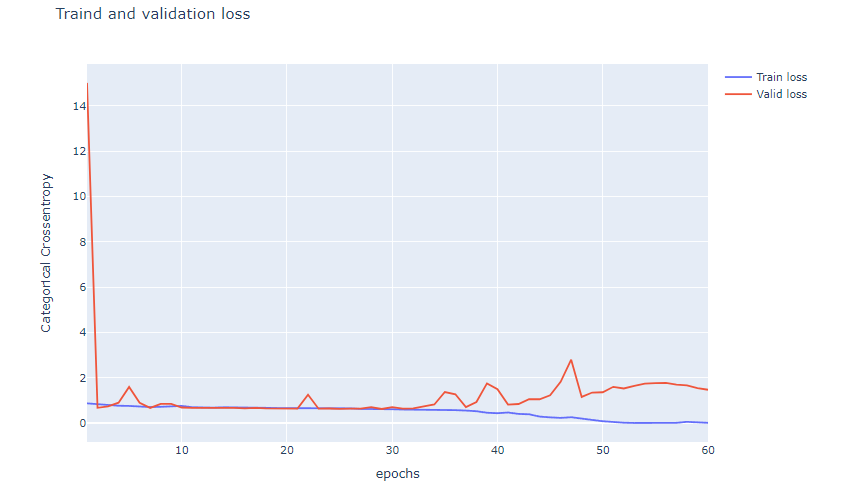

In [91]:
fig = go.Figure()
    
fig.add_trace(go.Scatter(
    x=list(range(1, num_epochs + 1)), 
    y=train_accs, 
    name='Train accuracy',
))
fig.add_trace(go.Scatter(
    x=list(range(1, num_epochs + 1)), 
    y=valid_accs, 
    name='Validation accuracy',
))

fig.update_layout(
    title='Traind and validation accuracy', 
    xaxis_title='epochs',
    yaxis_title='accuracy',
    width=900, 
    height=600
)
fig.show()

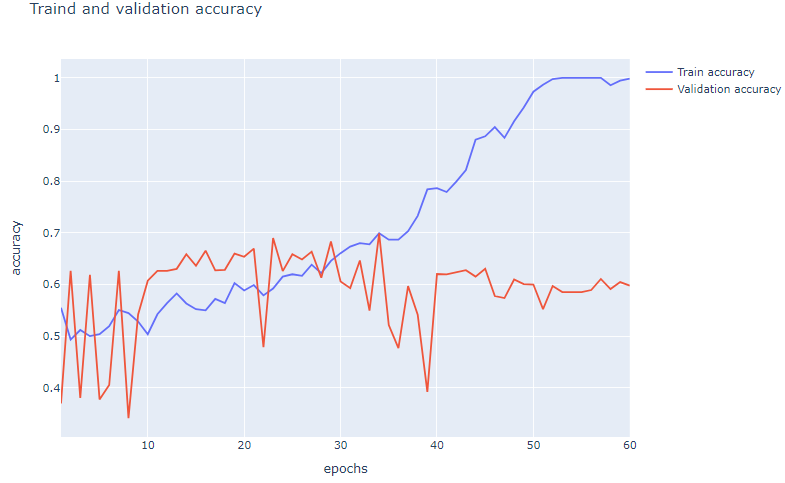

## Model overfits after ~30 epochs. Lets add horizontal flip as augmentation

In [161]:
optimizer = optim.Adam(model.parameters(), lr=learning_rate)
scheduler = optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.9)

lrs = []

for i in range(num_epochs):
    
    lrs.append(scheduler.get_last_lr()[0])
    scheduler.step()
    

fig = go.Figure()
    
fig.add_trace(go.Scatter(
    x=list(range(1, num_epochs + 1)), 
    y=lrs
))
fig.update_layout(
    xaxis_title='epochs',
    yaxis_title='Learning rate',
    width=900, 
    height=500
)
fig.show()

In [162]:
data_transforms.update({
    'train': transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize(mean=channel_means, std=channel_stds),
        transforms.Resize(size, interpolation=InterpolationMode.NEAREST),
        transforms.RandomHorizontalFlip(p=0.5),
    ])
})
image_datasets = {
    x: SpectogramDataset(
        df_spect.loc[(df_spect['Type'] == x)].reset_index(drop=True).copy(),
        data_transforms[x]
    ) for x in dataset_names
}
data_loaders = {
    x: DataLoader(
        image_datasets[x], 
        batch_size=batch_size, 
        num_workers=num_workers
    ) for x in dataset_names
}

In [163]:
model_name = 'CNNSpectogramAug.pt'
path_model = os.path.join(path_saved_models, model_name)

learning_rate = 1e-3

model = models.resnet18(pretrained=False)

num_ftrs = model.fc.in_features
model.fc = nn.Sequential(
    nn.Dropout(0.5),
    nn.Linear(num_ftrs, num_classes),
)
swa_model = torch.optim.swa_utils.AveragedModel(model)

optimizer = optim.Adam(model.parameters(), lr=learning_rate)
scheduler = optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.9)
criterion = nn.CrossEntropyLoss()

model.to(device)
criterion.to(device)

best_valid_loss = float('inf')
train_losses = []
train_accs = []
valid_losses = []
valid_accs = []

In [164]:
num_epochs = 30


for epoch in tqdm(range(num_epochs)):
    
    train_loss, train_acc = train(data_loaders['train'], model, criterion, optimizer, device)
    valid_loss, valid_acc = evaluate(data_loaders['valid'], model, criterion, device)
    scheduler.step()
    swa_model.update_parameters(model)

    train_losses.append(train_loss)
    train_accs.append(train_acc)
    valid_losses.append(valid_loss)
    valid_accs.append(valid_acc)

    if valid_loss < best_valid_loss:

        best_valid_loss = valid_loss
        torch.save(model.state_dict(), path_model)
        
    print(f'epoch: {epoch+1}')
    print(f'train_loss: {train_loss:.3f}, train_acc: {train_acc:.3f}')
    print(f'valid_loss: {valid_loss:.3f}, valid_acc: {valid_acc:.3f}')

        
model.load_state_dict(torch.load(path_model))

test_loss, test_acc = evaluate(data_loaders['test'], model, criterion, device)

print(f'test_loss: {test_loss:.3f}, test_acc: {test_acc:.3f}')

torch.optim.swa_utils.update_bn(data_loaders['test'], swa_model)

swa_model = swa_model.to(device)
test_loss, test_acc = evaluate(data_loaders['test'], swa_model, criterion, device)

print(f'SWA test_loss: {test_loss:.3f}, SWA test_acc: {test_acc:.3f}')

torch.save(swa_model.state_dict(), path_model.replace('.pt', '_SWA.pt'))

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

epoch: 1
train_loss: 0.877, train_acc: 0.539
valid_loss: 3.968, valid_acc: 0.374


  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

epoch: 2
train_loss: 0.792, train_acc: 0.518
valid_loss: 1.177, valid_acc: 0.369


  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

epoch: 3
train_loss: 0.758, train_acc: 0.516
valid_loss: 1.056, valid_acc: 0.369


  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

epoch: 4
train_loss: 0.751, train_acc: 0.548
valid_loss: 0.667, valid_acc: 0.626


  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

epoch: 5
train_loss: 0.723, train_acc: 0.562
valid_loss: 0.668, valid_acc: 0.634


  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

epoch: 6
train_loss: 0.725, train_acc: 0.545
valid_loss: 0.661, valid_acc: 0.626


  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

epoch: 7
train_loss: 0.742, train_acc: 0.536
valid_loss: 0.779, valid_acc: 0.381


  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

epoch: 8
train_loss: 0.725, train_acc: 0.545
valid_loss: 0.667, valid_acc: 0.626


  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

epoch: 9
train_loss: 0.701, train_acc: 0.561
valid_loss: 0.656, valid_acc: 0.622


  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

epoch: 10
train_loss: 0.683, train_acc: 0.568
valid_loss: 0.650, valid_acc: 0.626


  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

epoch: 11
train_loss: 0.690, train_acc: 0.578
valid_loss: 0.649, valid_acc: 0.639


  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

epoch: 12
train_loss: 0.681, train_acc: 0.589
valid_loss: 0.642, valid_acc: 0.626


  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

epoch: 13
train_loss: 0.675, train_acc: 0.580
valid_loss: 0.635, valid_acc: 0.642


  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

epoch: 14
train_loss: 0.670, train_acc: 0.606
valid_loss: 0.630, valid_acc: 0.630


  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

epoch: 15
train_loss: 0.675, train_acc: 0.574
valid_loss: 0.618, valid_acc: 0.640


  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

epoch: 16
train_loss: 0.648, train_acc: 0.621
valid_loss: 0.629, valid_acc: 0.657


  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

epoch: 17
train_loss: 0.647, train_acc: 0.632
valid_loss: 0.615, valid_acc: 0.653


  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

epoch: 18
train_loss: 0.643, train_acc: 0.629
valid_loss: 0.608, valid_acc: 0.668


  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

epoch: 19
train_loss: 0.641, train_acc: 0.630
valid_loss: 0.636, valid_acc: 0.668


  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

epoch: 20
train_loss: 0.628, train_acc: 0.670
valid_loss: 0.615, valid_acc: 0.675


  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

epoch: 21
train_loss: 0.619, train_acc: 0.676
valid_loss: 0.661, valid_acc: 0.677


  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

epoch: 22
train_loss: 0.605, train_acc: 0.676
valid_loss: 0.620, valid_acc: 0.675


  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

epoch: 23
train_loss: 0.592, train_acc: 0.681
valid_loss: 0.634, valid_acc: 0.678


  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

epoch: 24
train_loss: 0.573, train_acc: 0.716
valid_loss: 0.721, valid_acc: 0.568


  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

epoch: 25
train_loss: 0.578, train_acc: 0.702
valid_loss: 0.701, valid_acc: 0.603


  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

epoch: 26
train_loss: 0.532, train_acc: 0.727
valid_loss: 0.684, valid_acc: 0.661


  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

epoch: 27
train_loss: 0.511, train_acc: 0.751
valid_loss: 0.833, valid_acc: 0.525


  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

epoch: 28
train_loss: 0.484, train_acc: 0.767
valid_loss: 0.779, valid_acc: 0.587


  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

epoch: 29
train_loss: 0.452, train_acc: 0.784
valid_loss: 0.777, valid_acc: 0.601


  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

epoch: 30
train_loss: 0.425, train_acc: 0.795
valid_loss: 0.840, valid_acc: 0.643


  0%|          | 0/11 [00:00<?, ?it/s]

test_loss: 0.773, test_acc: 0.516


  0%|          | 0/11 [00:00<?, ?it/s]

SWA test_loss: 0.738, SWA test_acc: 0.510


In [165]:
fig = go.Figure()
    
fig.add_trace(go.Scatter(
    x=list(range(1, num_epochs + 1)), 
    y=train_losses, 
    name='Train loss',
))
fig.add_trace(go.Scatter(
    x=list(range(1, num_epochs + 1)), 
    y=valid_losses, 
    name='Validation loss',
))

fig.update_layout(
    title='Traind and validation loss', 
    xaxis_title='epochs',
    yaxis_title='Categorical Crossentropy',
    width=900, 
    height=600
)
fig.show()

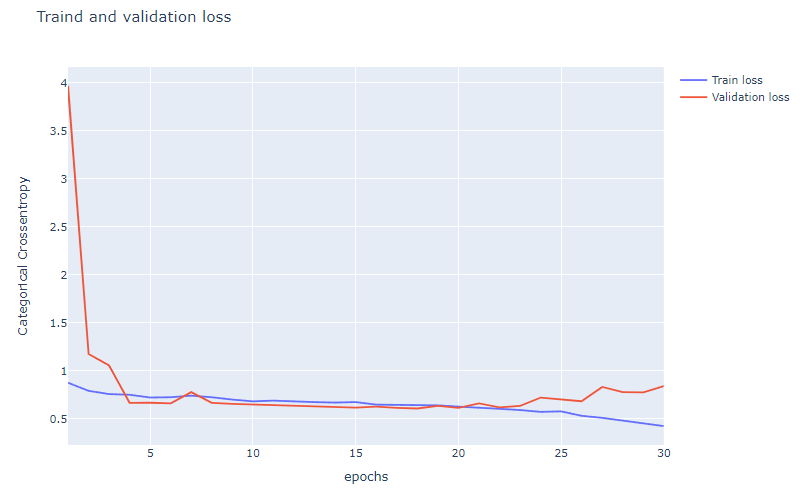

In [166]:
fig = go.Figure()
    
fig.add_trace(go.Scatter(
    x=list(range(1, num_epochs + 1)), 
    y=train_accs, 
    name='Train accuracy',
))
fig.add_trace(go.Scatter(
    x=list(range(1, num_epochs + 1)), 
    y=valid_accs, 
    name='Validation accuracy',
))

fig.update_layout(
    title='Traind and validation accuracy', 
    xaxis_title='epochs',
    yaxis_title='accuracy',
    width=900, 
    height=600
)
fig.show()

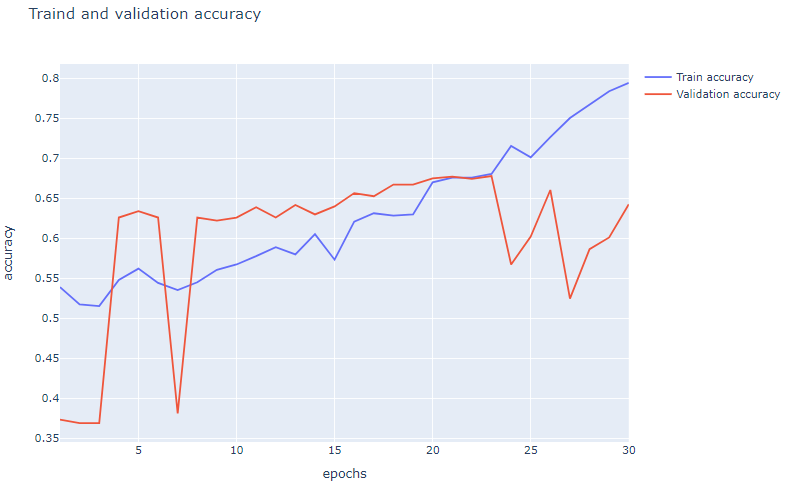

## The performance is slightly decreased. I tried several augmentation methods, but at the end none of them produced better results. The models are saved according to the best validation scores.